In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#result
datapath = '../training_data/'

dset = 'resonant/'
#default setting
Norbits = 1e4 
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'oldfeatures/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
#name of hyperparams
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}
# measure how the model perform
def objective(params):
    clf = XGBClassifier(n_jobs =16, n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.2, seed = 0)
    # change learning rate higher, to make it run faster
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=True)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [6]:
trainX

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
0,0.060234,0.030043,0.000283,0.491222,0.504063,0.000882,0.000330,NaN,99.671099,21.854886
1,0.080547,0.017239,0.000138,0.432211,0.240504,0.008924,0.002141,0.008266,161.968909,40.989718
2,0.129660,0.028785,0.000989,1.000486,1.001981,0.000513,0.000936,0.010448,167.402468,51.758073
3,0.406112,0.038118,0.000942,0.348009,0.427768,0.035020,0.003593,0.012846,NaN,NaN
4,0.059897,0.026167,0.001919,0.285146,0.257596,0.052339,0.001386,0.032904,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
90829,0.074312,NaN,NaN,NaN,0.215931,NaN,NaN,NaN,NaN,NaN
90830,0.096856,0.027344,0.000538,0.058377,0.143569,0.073979,0.007292,0.034311,117.447095,30.524364
90831,0.117699,0.022715,0.000186,0.102769,0.688408,0.001424,0.000577,NaN,93.535492,24.585642
90832,0.170846,0.153141,0.016777,0.009590,0.405397,0.034448,0.000035,0.871902,86.652101,23.867585


In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                                                                                          
0.90705548                                                                                                                      
ERROR                                                                                                                           
0.0023007369081147044                                                                                                           
SCORE:                                                                                                                          
0.9073587000000002                                                                                                              
ERROR                                                                                                                           
0.0019830559912284392                                                                            

ERROR                                                                                                                           
0.0025192687986917957                                                                                                           
SCORE:                                                                                                                          
0.9050562799999999                                                                                                              
ERROR                                                                                                                           
0.0025289165972874512                                                                                                           
SCORE:                                                                                                                          
0.9077683599999998                                                                               

SCORE:                                                                                                                          
0.9058906                                                                                                                       
ERROR                                                                                                                           
0.0027260894889655535                                                                                                           
SCORE:                                                                                                                          
0.90772136                                                                                                                      
ERROR                                                                                                                           
0.0026642710111960603                                                                            

ERROR                                                                                                                           
0.0025112572191481213                                                                                                           
SCORE:                                                                                                                          
0.90390912                                                                                                                      
ERROR                                                                                                                           
0.0024599800834188973                                                                                                           
SCORE:                                                                                                                          
0.8874316                                                                                        

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

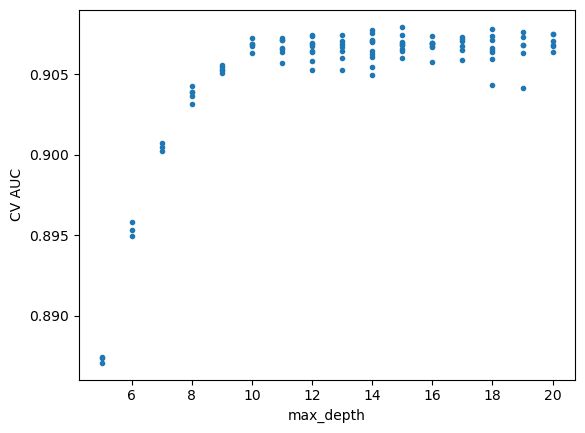

In [6]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

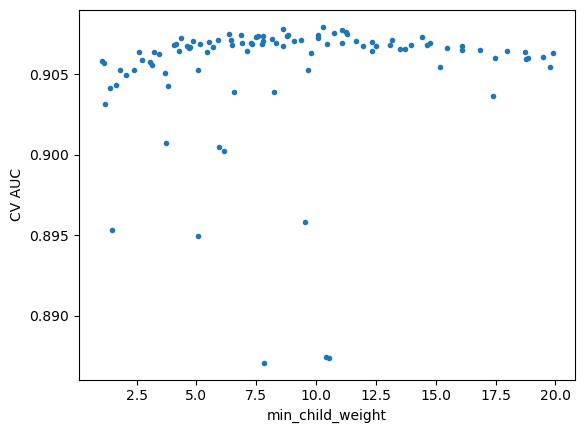

In [7]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')

ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

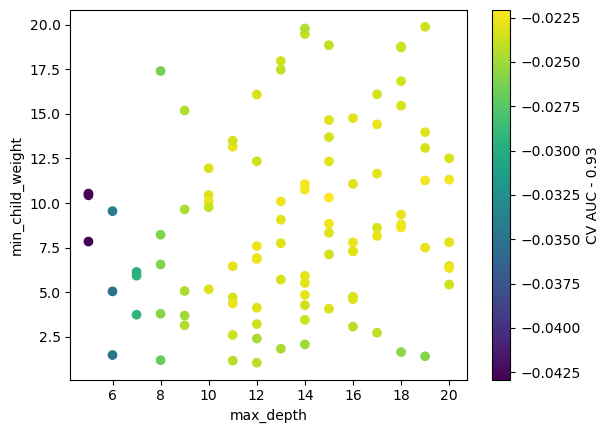

In [8]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 13, so choose the least complex model

In [17]:
# model = XGBClassifier(learning_rate = 0.05, 
#                          max_depth = 13, 
#                          subsample = 0.95,
#                          min_child_weight = 5)
model = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5)
score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.92923+0.00062	test-auc:0.88508+0.00300
[1]	train-auc:0.93931+0.00199	test-auc:0.89450+0.00255
[2]	train-auc:0.94444+0.00116	test-auc:0.89868+0.00353
[3]	train-auc:0.94658+0.00125	test-auc:0.90078+0.00408
[4]	train-auc:0.94869+0.00151	test-auc:0.90294+0.00389
[5]	train-auc:0.95059+0.00130	test-auc:0.90423+0.00375
[6]	train-auc:0.95215+0.00119	test-auc:0.90554+0.00381
[7]	train-auc:0.95331+0.00124	test-auc:0.90637+0.00368
[8]	train-auc:0.95440+0.00122	test-auc:0.90726+0.00374
[9]	train-auc:0.95545+0.00092	test-auc:0.90800+0.00336
[10]	train-auc:0.95640+0.00101	test-auc:0.90858+0.00336
[11]	train-auc:0.95715+0.00100	test-auc:0.90914+0.00320
[12]	train-auc:0.95794+0.00089	test-auc:0.90959+0.00315
[13]	train-auc:0.95896+0.00076	test-auc:0.91038+0.00294
[14]	train-auc:0.95965+0.00069	test-auc:0.91081+0.00288
[15]	train-auc:0.96037+0.00060	test-auc:0.91117+0.00267
[16]	train-auc:0.96103+0.00058	test-auc:0.91159+0.00266
[17]	train-auc:0.96170+0.00058	test-auc:0.91196+0.00259
[1

[146]	train-auc:0.99349+0.00016	test-auc:0.92731+0.00181
[147]	train-auc:0.99359+0.00017	test-auc:0.92739+0.00181
[148]	train-auc:0.99370+0.00017	test-auc:0.92747+0.00179
[149]	train-auc:0.99379+0.00018	test-auc:0.92754+0.00182
[150]	train-auc:0.99387+0.00019	test-auc:0.92758+0.00180
[151]	train-auc:0.99395+0.00020	test-auc:0.92763+0.00180
[152]	train-auc:0.99403+0.00021	test-auc:0.92769+0.00178
[153]	train-auc:0.99412+0.00020	test-auc:0.92777+0.00177
[154]	train-auc:0.99419+0.00020	test-auc:0.92784+0.00180
[155]	train-auc:0.99427+0.00019	test-auc:0.92792+0.00180
[156]	train-auc:0.99434+0.00020	test-auc:0.92796+0.00181
[157]	train-auc:0.99442+0.00018	test-auc:0.92801+0.00180
[158]	train-auc:0.99449+0.00018	test-auc:0.92807+0.00179
[159]	train-auc:0.99456+0.00019	test-auc:0.92810+0.00177
[160]	train-auc:0.99463+0.00021	test-auc:0.92817+0.00180
[161]	train-auc:0.99470+0.00023	test-auc:0.92820+0.00182
[162]	train-auc:0.99476+0.00024	test-auc:0.92823+0.00182
[163]	train-auc:0.99483+0.00024

[290]	train-auc:0.99875+0.00033	test-auc:0.93115+0.00199
[291]	train-auc:0.99877+0.00033	test-auc:0.93117+0.00198
[292]	train-auc:0.99877+0.00033	test-auc:0.93118+0.00198
[293]	train-auc:0.99879+0.00032	test-auc:0.93119+0.00198
[294]	train-auc:0.99880+0.00033	test-auc:0.93119+0.00198
[295]	train-auc:0.99881+0.00032	test-auc:0.93121+0.00198
[296]	train-auc:0.99883+0.00032	test-auc:0.93122+0.00196
[297]	train-auc:0.99884+0.00032	test-auc:0.93123+0.00198
[298]	train-auc:0.99886+0.00032	test-auc:0.93123+0.00199
[299]	train-auc:0.99887+0.00032	test-auc:0.93125+0.00198
[300]	train-auc:0.99889+0.00031	test-auc:0.93128+0.00197
[301]	train-auc:0.99890+0.00031	test-auc:0.93128+0.00197
[302]	train-auc:0.99891+0.00031	test-auc:0.93130+0.00198
[303]	train-auc:0.99892+0.00031	test-auc:0.93132+0.00199
[304]	train-auc:0.99894+0.00031	test-auc:0.93133+0.00198
[305]	train-auc:0.99895+0.00030	test-auc:0.93135+0.00198
[306]	train-auc:0.99896+0.00030	test-auc:0.93137+0.00198
[307]	train-auc:0.99896+0.00030

# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

Text(0, 0.5, 'CV AUC score')

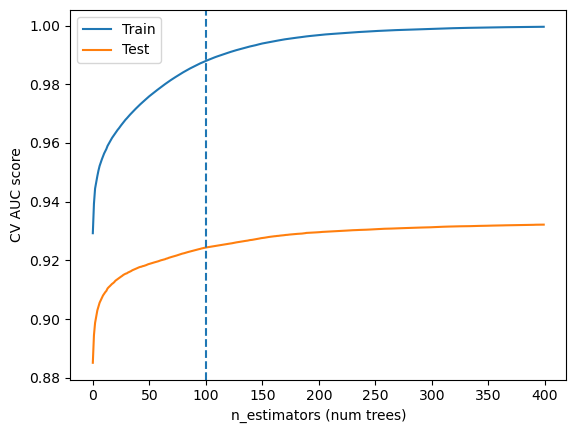

In [18]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [19]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:51:26] WARNING: /croot/xgboost-split_1675119646044/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=20, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
model.save_model(datapath+'../spock/models/spock.json')

In [24]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0.5, 1.0, 'ROC curve (AUC = 0.903)')

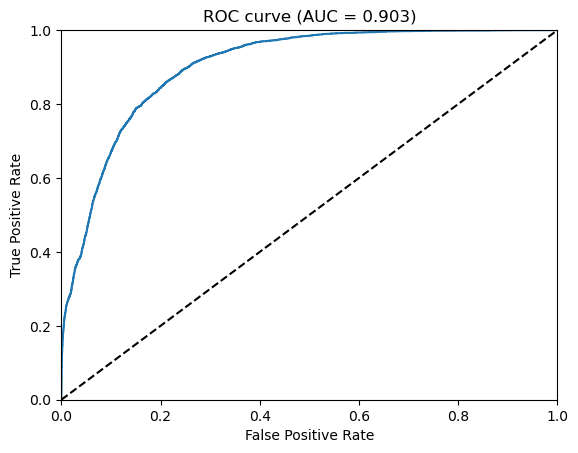

In [20]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [15]:
stride = 10
np.savetxt('../spock/models/resROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))

In [16]:
ROCthresholds, tpr, fpr = np.loadtxt('../spock/models/resROC.txt')
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9896588325500488, TPR = 0.0, FPR = 0.0
Threshold 0.8918883800506592, TPR = 0.2820996978851964, FPR = 0.004364555217366336
Threshold 0.8338184356689453, TPR = 0.408987915407855, FPR = 0.009245965657841842
Threshold 0.7911725640296936, TPR = 0.47658610271903323, FPR = 0.01418480445644059
Threshold 0.745854914188385, TPR = 0.5404078549848943, FPR = 0.019525641761902027
Threshold 0.705155074596405, TPR = 0.589690332326284, FPR = 0.025211049216102913
Threshold 0.6644747257232666, TPR = 0.6355740181268882, FPR = 0.031183598460920003
Threshold 0.6241954565048218, TPR = 0.6714501510574018, FPR = 0.03790271636133923
Threshold 0.5779088735580444, TPR = 0.7063821752265861, FPR = 0.044449549187388734
Threshold 0.5285456776618958, TPR = 0.7379154078549849, FPR = 0.05243209096651927
Threshold 0.48045119643211365, TPR = 0.771714501510574, FPR = 0.060931487968758975
Threshold 0.43897873163223267, TPR = 0.7938066465256798, FPR = 0.07184287601217482
Threshold 0.3960135579109192, TPR = 0.8164

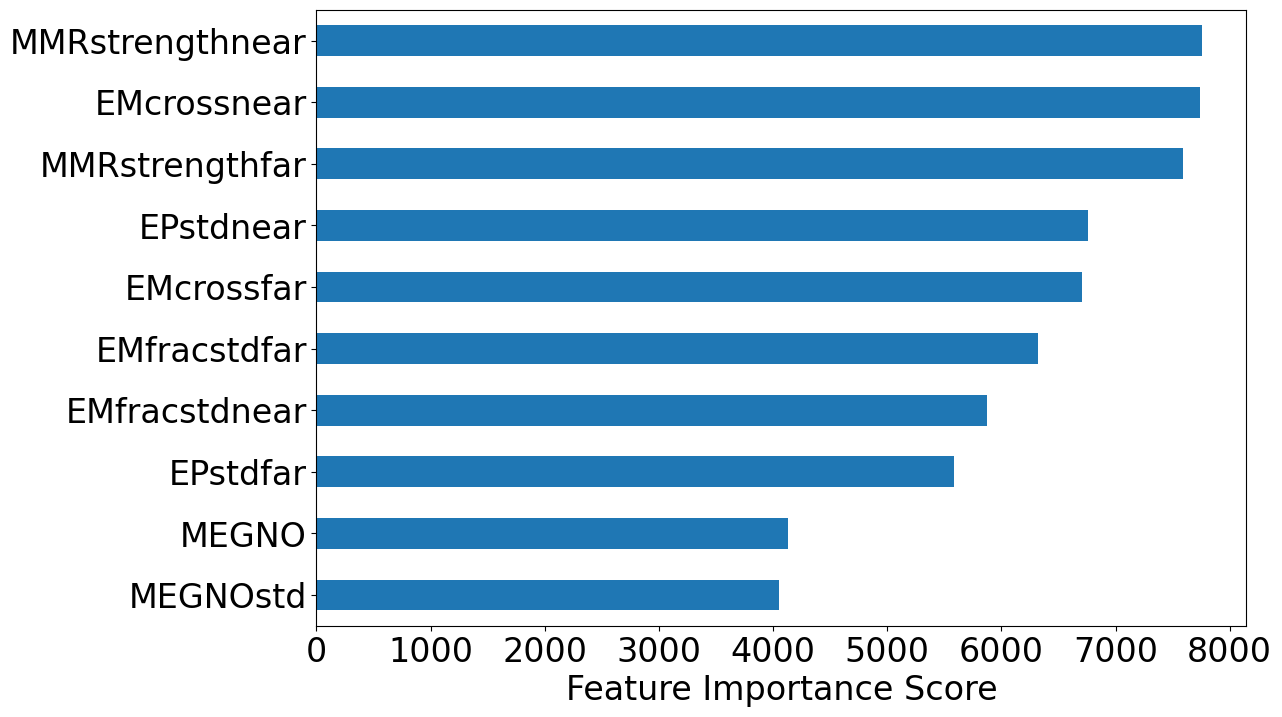

In [26]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [18]:
feat_imp

EMcrossnear        6844
MMRstrengthnear    6568
MMRstrengthfar     6392
EPstdnear          6161
EMfracstdfar       5815
EMfracstdnear      5509
EMcrossfar         5077
EPstdfar           5009
MEGNOstd           4763
MEGNO              4350
dtype: int64

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


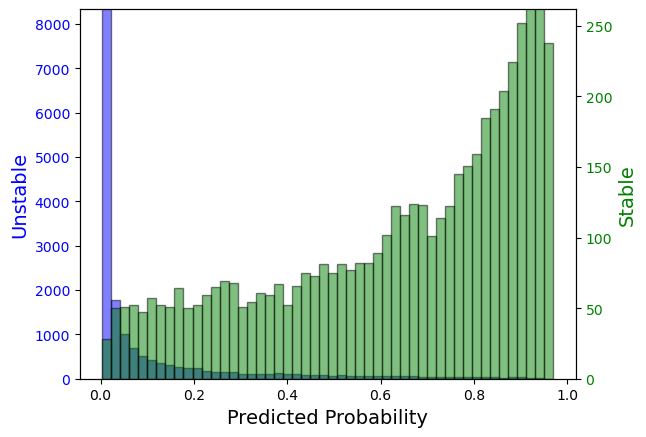

In [27]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100
fig.savefig('stable_unstable_comparison.png')

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0, 0.5, 'Fraction actually stable')

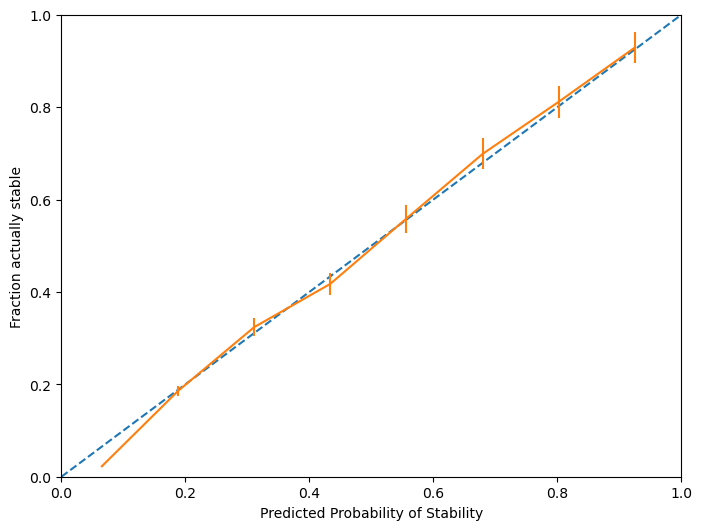

In [28]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

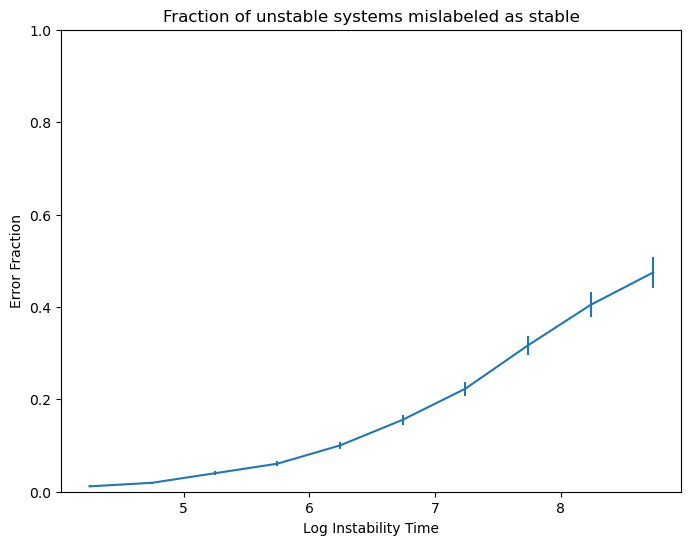

In [29]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')